cuda:0


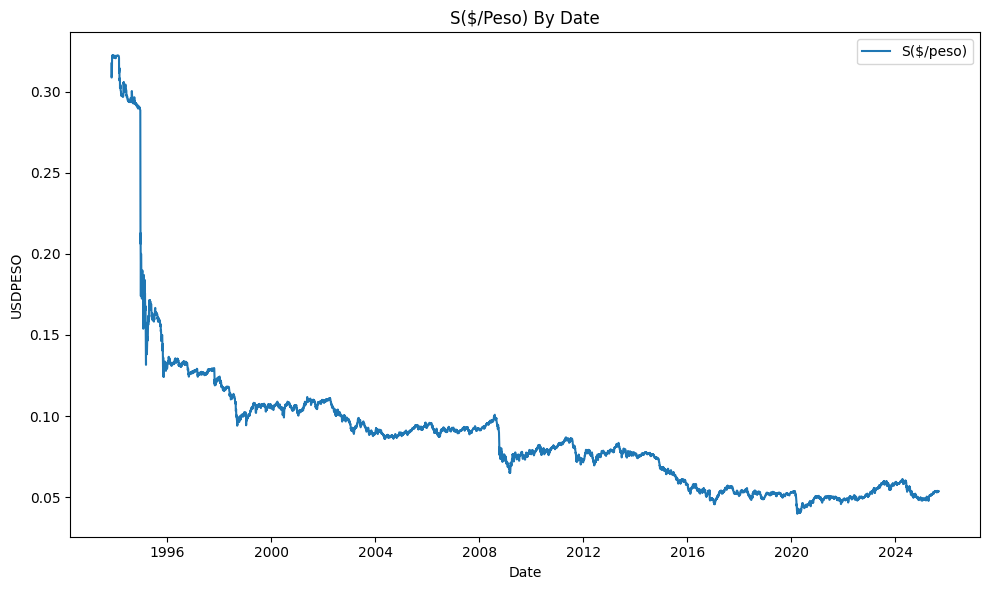

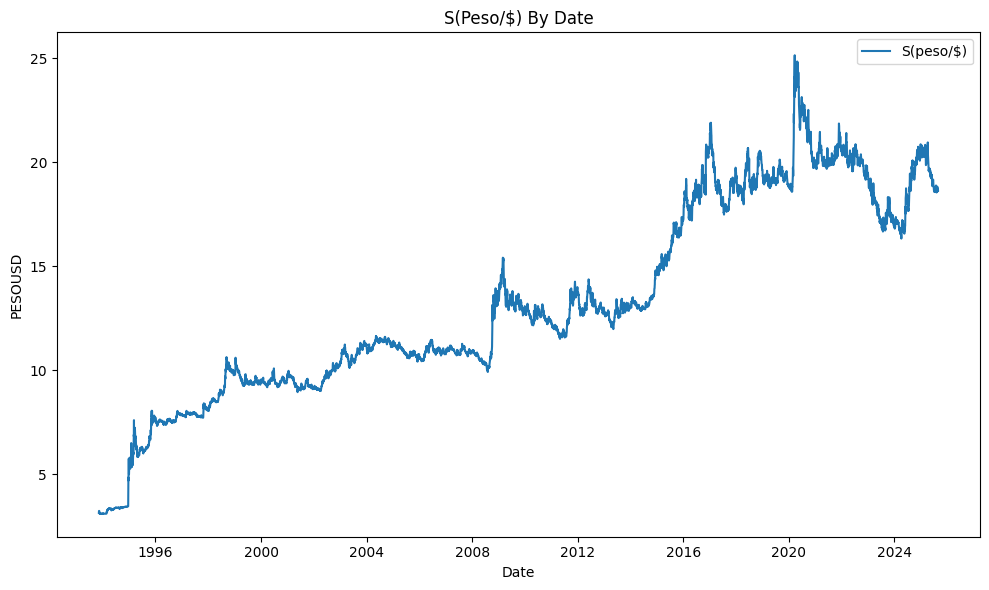

In [1]:
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import mlflow
import mlflow.pytorch
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_percentage_error
from dotenv import load_dotenv
import os
load_dotenv()

fred_api_key = os.getenv("FRED_API_KEY")

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)




pesousd = fred.get_series("DEXMXUS")
pesousd.name = "PESOUSD"

df = pd.concat([pesousd],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

df['USDPESO']  = 1 / df['PESOUSD']


plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDPESO',data=df,label="S($/peso)")
plt.title("S($/Peso) By Date")
plt.savefig("images/spotrate-USD-PESO.png")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='PESOUSD',data=df,label="S(peso/$)")
plt.title("S(Peso/$) By Date")
plt.savefig("images/spotrate-PESO-USD.png")
plt.tight_layout()
plt.show()

In [2]:
A = np.array([[df['USDPESO'][1],df['PESOUSD'][1]],[df['PESOUSD'][1],df['USDPESO'][1]]])
print(f'1:1 Ratio of Currency Pairs: {A}')

1:1 Ratio of Currency Pairs: [[0.30864198 3.24      ]
 [3.24       0.30864198]]


In [3]:
df.drop('PESOUSD',inplace=True,axis=1)
df.drop_duplicates(inplace=True)


In [4]:
# training


training = df.iloc[:,1:2].values



train_size = int(len(training) * .80)


train_data = training[:train_size]
test_data = training[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length):
        Xi = dataframe[i:(i+seq_length)]
        yi = dataframe[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 1

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()






class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.gru(X, h0)
        out = self.fc(out[:,-1,:])
        return out


input_size = 1
hidden_size = 256
num_layers = 1
output_size = 1

gru_model = GRU(input_size,hidden_size,num_layers,output_size)
epochs = 500
learning_rate = 0.001
optimizer_gru = torch.optim.Adam(params=gru_model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()


In [5]:
with mlflow.start_run() as run:

    mlflow.log_params({
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "output_size": output_size,
        "epochs": epochs,
        "learning_rate": learning_rate,
        "optimizer": optimizer_gru.__class__.__name__,
        "loss_function": loss_fn.__class__.__name__
    }) 

    for epoch in range(epochs):
        y_pred = gru_model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        optimizer_gru.zero_grad()
        loss.backward()
        optimizer_gru.step()

        if epoch % 1 != 0:
            continue

        gru_model.eval()
        with torch.no_grad():
            y_pred_train = gru_model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred_train, y_train))
            y_pred_test = gru_model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred_test, y_test))
            print(f'Epoch: {epoch}; train_RMSE: {train_rmse:.4}; Test RMSE: {test_rmse:.4}')

         
            mlflow.log_metric("train_rmse", train_rmse, step=epoch) 
            mlflow.log_metric("test_rmse", test_rmse, step=epoch) 


    mlflow.pytorch.log_model(pytorch_model=gru_model, artifact_path="gru_model")

/tmp/ipykernel_41636/1312972333.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred_train, y_train))
/tmp/ipykernel_41636/1312972333.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred_test, y_test))


Epoch: 0; train_RMSE: 0.225; Test RMSE: 0.04116
Epoch: 1; train_RMSE: 0.2171; Test RMSE: 0.05197
Epoch: 2; train_RMSE: 0.2095; Test RMSE: 0.06292
Epoch: 3; train_RMSE: 0.2025; Test RMSE: 0.07391
Epoch: 4; train_RMSE: 0.1961; Test RMSE: 0.08485
Epoch: 5; train_RMSE: 0.1902; Test RMSE: 0.0957
Epoch: 6; train_RMSE: 0.185; Test RMSE: 0.1064
Epoch: 7; train_RMSE: 0.1804; Test RMSE: 0.1169
Epoch: 8; train_RMSE: 0.1765; Test RMSE: 0.1272
Epoch: 9; train_RMSE: 0.1733; Test RMSE: 0.1371
Epoch: 10; train_RMSE: 0.1708; Test RMSE: 0.1465
Epoch: 11; train_RMSE: 0.1689; Test RMSE: 0.1554
Epoch: 12; train_RMSE: 0.1676; Test RMSE: 0.1636
Epoch: 13; train_RMSE: 0.1667; Test RMSE: 0.1711
Epoch: 14; train_RMSE: 0.1662; Test RMSE: 0.1776
Epoch: 15; train_RMSE: 0.1658; Test RMSE: 0.1831
Epoch: 16; train_RMSE: 0.1656; Test RMSE: 0.1875
Epoch: 17; train_RMSE: 0.1653; Test RMSE: 0.1908
Epoch: 18; train_RMSE: 0.1649; Test RMSE: 0.1929
Epoch: 19; train_RMSE: 0.1643; Test RMSE: 0.194
Epoch: 20; train_RMSE: 0.163

2025/09/05 14:27:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch: 499; train_RMSE: 0.005187; Test RMSE: 0.003389


2025/09/05 14:27:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Mean Absolute Percentage Error: 0.0168
R2 Score: 94.84%
Root Mean Squared Error: 0.0009375


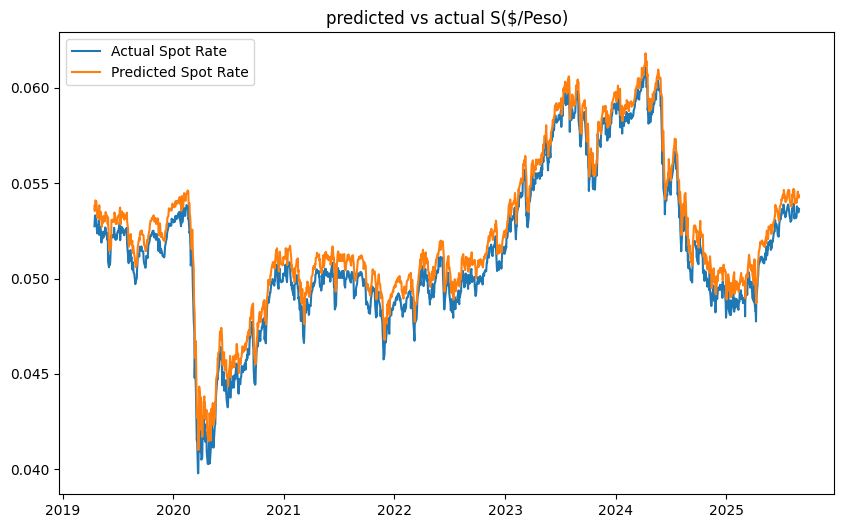

In [6]:
with torch.no_grad():
    pred = gru_model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length:]['Date']


gru_comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})


# MAPE
mape = mean_absolute_percentage_error(actual_rescaled,pred_rescaled)
print(f'Mean Absolute Percentage Error: {mape:.4f}')

#r2 score
r2 = r2_score(actual_rescaled,pred_rescaled)
print(f'R2 Score: {r2*100:.2f}%')

#Root Mean Squared Error

rmse = root_mean_squared_error(actual_rescaled,pred_rescaled)
print(f'Root Mean Squared Error: {rmse:.4}')



plt.figure(figsize=(10,6))
plt.plot(gru_comparison_df['Date'],gru_comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(gru_comparison_df['Date'],gru_comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.title("predicted vs actual S($/Peso)")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate_gru-usd-peso.png")
plt.show()


In [7]:


print(np.round(gru_comparison_df,4).head(20))
print(np.round(gru_comparison_df,4).tail(20))

           Date  Actual Spot Rate  Predicted Spot Rate
6381 2019-04-16            0.0527               0.0538
6382 2019-04-17            0.0531               0.0535
6383 2019-04-18            0.0533               0.0539
6384 2019-04-19            0.0533               0.0541
6385 2019-04-22            0.0531               0.0541
6386 2019-04-23            0.0528               0.0539
6387 2019-04-24            0.0526               0.0536
6388 2019-04-25            0.0524               0.0534
6389 2019-04-26            0.0528               0.0532
6390 2019-04-29            0.0526               0.0536
6391 2019-04-30            0.0526               0.0534
6392 2019-05-01            0.0530               0.0535
6393 2019-05-02            0.0523               0.0538
6394 2019-05-03            0.0527               0.0531
6395 2019-05-06            0.0527               0.0535
6396 2019-05-07            0.0525               0.0535
6397 2019-05-08            0.0524               0.0533
6398 2019-